In [74]:
import os
import pandas as pd
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
# sklearn.metrics.accuracy_score
import xgboost as xgb
import numpy as np
import itertools 
import tqdm
from time import sleep
import random
# from docx import Document
# import docx2txt
from datetime import datetime
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import nltk
import re
import matplotlib.pyplot as plt

In [52]:
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /home/litian/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/litian/nltk_data...


True

In [ ]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# mannually generate the search grid
def makeGrid(pars_dict):  
    keys=pars_dict.keys()
    combinations=itertools.product(*pars_dict.values())
    ds=[dict(zip(keys,cc)) for cc in combinations]
    return ds

# Data Preparation

In [3]:
df_raw = pd.read_excel("../Dataset/MergedDataset_231207_ForElly_Excel.xlsx")

# Remove "." in the feature column
row_num, column_num = df_raw.shape
for rowID in range(row_num):
    for columnID in range(column_num):
        if "." == df_raw.iloc[rowID, columnID]:
            df_raw.iloc[rowID, columnID] = np.nan

# prepare the feature list
featureList = []
for item in df_raw.columns:
    if item.startswith("Item"):
        featureList.append(item)

patientList = []
roundList = []
for idx, row in df_raw.iterrows():
    patient = int(str(row["IAPTus_Num"]).split("_")[0])
    if "_" in str(row["IAPTus_Num"]):
        Round = int(str(row["IAPTus_Num"]).split("_")[1])
    else:
        Round = 0
    patientList.append(patient)
    roundList.append(Round)
df_raw["patient"] = patientList
df_raw["round"] = roundList

In [4]:
df_referral = pd.read_json("../Dataset/ReferralLetterSummary.json", lines=True)

In [5]:
df = pd.merge(df_raw, df_referral, on=["patient","round"])

# Label Preparation

## Here I use RecoveryDesc, not the EndDesc as the prediction target. EndDesc has 4 label categories and Referral Letter has only 44 data points, so it does not meet the conditions for tuning.

In [6]:
df = df[df["RecoveryDesc"] == df["RecoveryDesc"]]
df = df[(df["RecoveryDesc"].isin(["At recovery", "Not at recovery"]))]
df.reset_index().drop("index", axis=1)
print(df.shape)

labelList = []
for idx, row in df.iterrows():
    if (row["ReliableChangeDesc"] == "Reliable improvement") & (row["ReliableRecoveryDesc"] == "Reliable recovery") & (row["RecoveryDesc"] == "At recovery"):
        labelList.append(1)
    else:
        labelList.append(0)
df["labels"] = np.array(labelList, dtype=float)
labelList = ["labels"]

(43, 285)


In [7]:
df = df[["IAPTus_Num_x","patient","round","text", "summarization", "labels"]]
df = df.reset_index().drop("index", axis=1)

# Train

In [10]:
# First I will use LDA to generate features (topics), then apply each document on LDA model to get its corresponding feature values. 
# After that I will use classifier to do prediction

In [11]:
from time import time
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [56]:
def tokenize(text, doPreprocessing=True, doLemma=True):
    if doPreprocessing:
        text = " ".join(re.sub(r'[^\w\s]', ' ', text).replace("\n", " ").split())
    # tokens = [x for x in nltk.word_tokenize(text)]
    #print(text)
    tokens = text.split()
    # print(tokens)
    if doLemma:
        # stemmer = SnowballStemmer("english")
        lemma = nltk.wordnet.WordNetLemmatizer()
        tokens = [lemma.lemmatize(item) for item in tokens]
    return tokens

tokenize(df.iloc[1]["summarization"])

['Patient',
 'Background',
 'NAME',
 'a',
 'university',
 'student',
 'ha',
 'a',
 'history',
 'of',
 'anxiety',
 'depression',
 'and',
 'generalized',
 'anxiety',
 'disorder',
 'She',
 'ha',
 'experienced',
 'panic',
 'attack',
 'and',
 'developed',
 'compulsive',
 'behavior',
 'including',
 'self',
 'induced',
 'vomiting',
 'which',
 'she',
 'ha',
 'since',
 'stopped',
 'She',
 'ha',
 'a',
 'family',
 'history',
 'of',
 'a',
 'relative',
 'passing',
 'away',
 'from',
 'a',
 'condition',
 'adding',
 'to',
 'her',
 'grief',
 'Currently',
 'she',
 'is',
 'taking',
 'sertraline',
 'and',
 'propanol',
 'and',
 'her',
 'GP',
 'recommends',
 'exercise',
 'and',
 'distraction',
 'technique',
 'Symptoms',
 'and',
 'Impacts',
 'Symptoms',
 'Panic',
 'attack',
 'suicidal',
 'ideation',
 'past',
 'compulsive',
 'behavior',
 'overthinking',
 'social',
 'withdrawal',
 'Impacts',
 'Daily',
 'life',
 'is',
 'debilitating',
 'affecting',
 'sleep',
 'eating',
 'and',
 'hobby',
 'Studies',
 'are',
 'im

In [62]:
vectorizer = CountVectorizer(
    tokenizer=tokenize,
    max_df=0.95, 
    min_df=2, 
    max_features=10000, 
    stop_words="english"
)

tf = vectorizer.fit_transform(df["summarization"])

In [63]:
vectorizer.get_feature_names_out()

array(['13', '15', '18', '20', '2022', '3', '40mg', '50mg', '6', '8', '9',
       'academic', 'acceptance', 'access', 'acted', 'acting', 'action',
       'activity', 'additional', 'address', 'addressed', 'addressing',
       'adviser', 'affected', 'affecting', 'afternoon', 'age', 'ago',
       'aim', 'anorexia', 'app', 'appetite', 'apps', 'art', 'assessment',
       'assignment', 'associated', 'attending', 'attends', 'avoid',
       'avoiding', 'avoids', 'away', 'behavior', 'bessie', 'best',
       'better', 'body', 'boyfriend', 'break', 'breaking', 'brother',
       'calm', 'card', 'cessation', 'challenge', 'check', 'chronic',
       'class', 'client', 'close', 'college', 'completing', 'complex',
       'complexity', 'comprehensive', 'compulsion', 'compulsive',
       'conclusion', 'condition', 'conscious', 'consciousness',
       'consider', 'consideration', 'considering', 'contact',
       'contacting', 'contributed', 'counseling', 'counselling',
       'counsellor', 'counselor', 'c

In [195]:
num_topic = 5 * 2
# lda = LatentDirichletAllocation(
#     n_components=num_topic,
#     max_iter=5,
#     learning_method="online",
#     learning_offset=50.0,
#     random_state=0,
# )

lda = LatentDirichletAllocation(
    n_components=num_topic,
    max_iter=1,
    learning_method="online",
    learning_offset=100000.0,
    random_state=0,
)

W1 = lda.fit_transform(tf)
H1 = lda.components_

In [196]:
W1

array([[7.52103797e-04, 5.28641400e-02, 7.52106700e-04, 1.09050735e-01,
        2.39735584e-01, 2.11228891e-01, 3.83360126e-01, 7.52106422e-04,
        7.52102129e-04, 7.52104130e-04],
       [8.62324977e-04, 8.62326530e-04, 1.16308065e-01, 8.62328308e-04,
        8.62319702e-04, 5.06693092e-01, 3.70962562e-01, 8.62327352e-04,
        8.62326857e-04, 8.62326268e-04],
       [9.17703419e-04, 2.54001256e-02, 9.17697537e-04, 9.17707437e-04,
        9.17705475e-04, 6.98996859e-01, 9.17707407e-04, 9.17705032e-04,
        9.17701374e-04, 2.69179088e-01],
       [9.26197752e-04, 6.16894662e-01, 9.26202175e-04, 9.26198976e-04,
        9.26190553e-04, 3.75695745e-01, 9.26202513e-04, 9.26197616e-04,
        9.26199178e-04, 9.26204120e-04],
       [1.14976576e-03, 1.14976918e-03, 8.59553688e-01, 1.14977181e-03,
        1.14976942e-03, 1.31248170e-01, 1.14976885e-03, 1.14976603e-03,
        1.14975800e-03, 1.14977250e-03],
       [5.06009596e-02, 2.97018320e-01, 1.13670472e-03, 1.13670678e-03,
   

In [197]:
H1

array([[1.18320549, 1.03742594, 1.1952457 , ..., 1.05373876, 0.87400139,
        0.88410026],
       [0.88728715, 0.92241407, 1.05362186, ..., 1.07630722, 0.99314456,
        1.03224235],
       [1.08784457, 0.96947624, 0.9935828 , ..., 0.92083133, 0.96688619,
        1.18802976],
       ...,
       [1.00212215, 0.9959363 , 0.98952598, ..., 1.05021866, 1.08929262,
        0.99544875],
       [0.88254313, 1.06366292, 0.8917554 , ..., 0.85945439, 0.99914819,
        0.8972253 ],
       [1.18252943, 0.99181976, 0.93759928, ..., 0.86203277, 0.95295827,
        1.05998267]])

In [198]:
H1.shape[0] / 5

2.0

In [199]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(int(model.components_.shape[0] / 5), 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

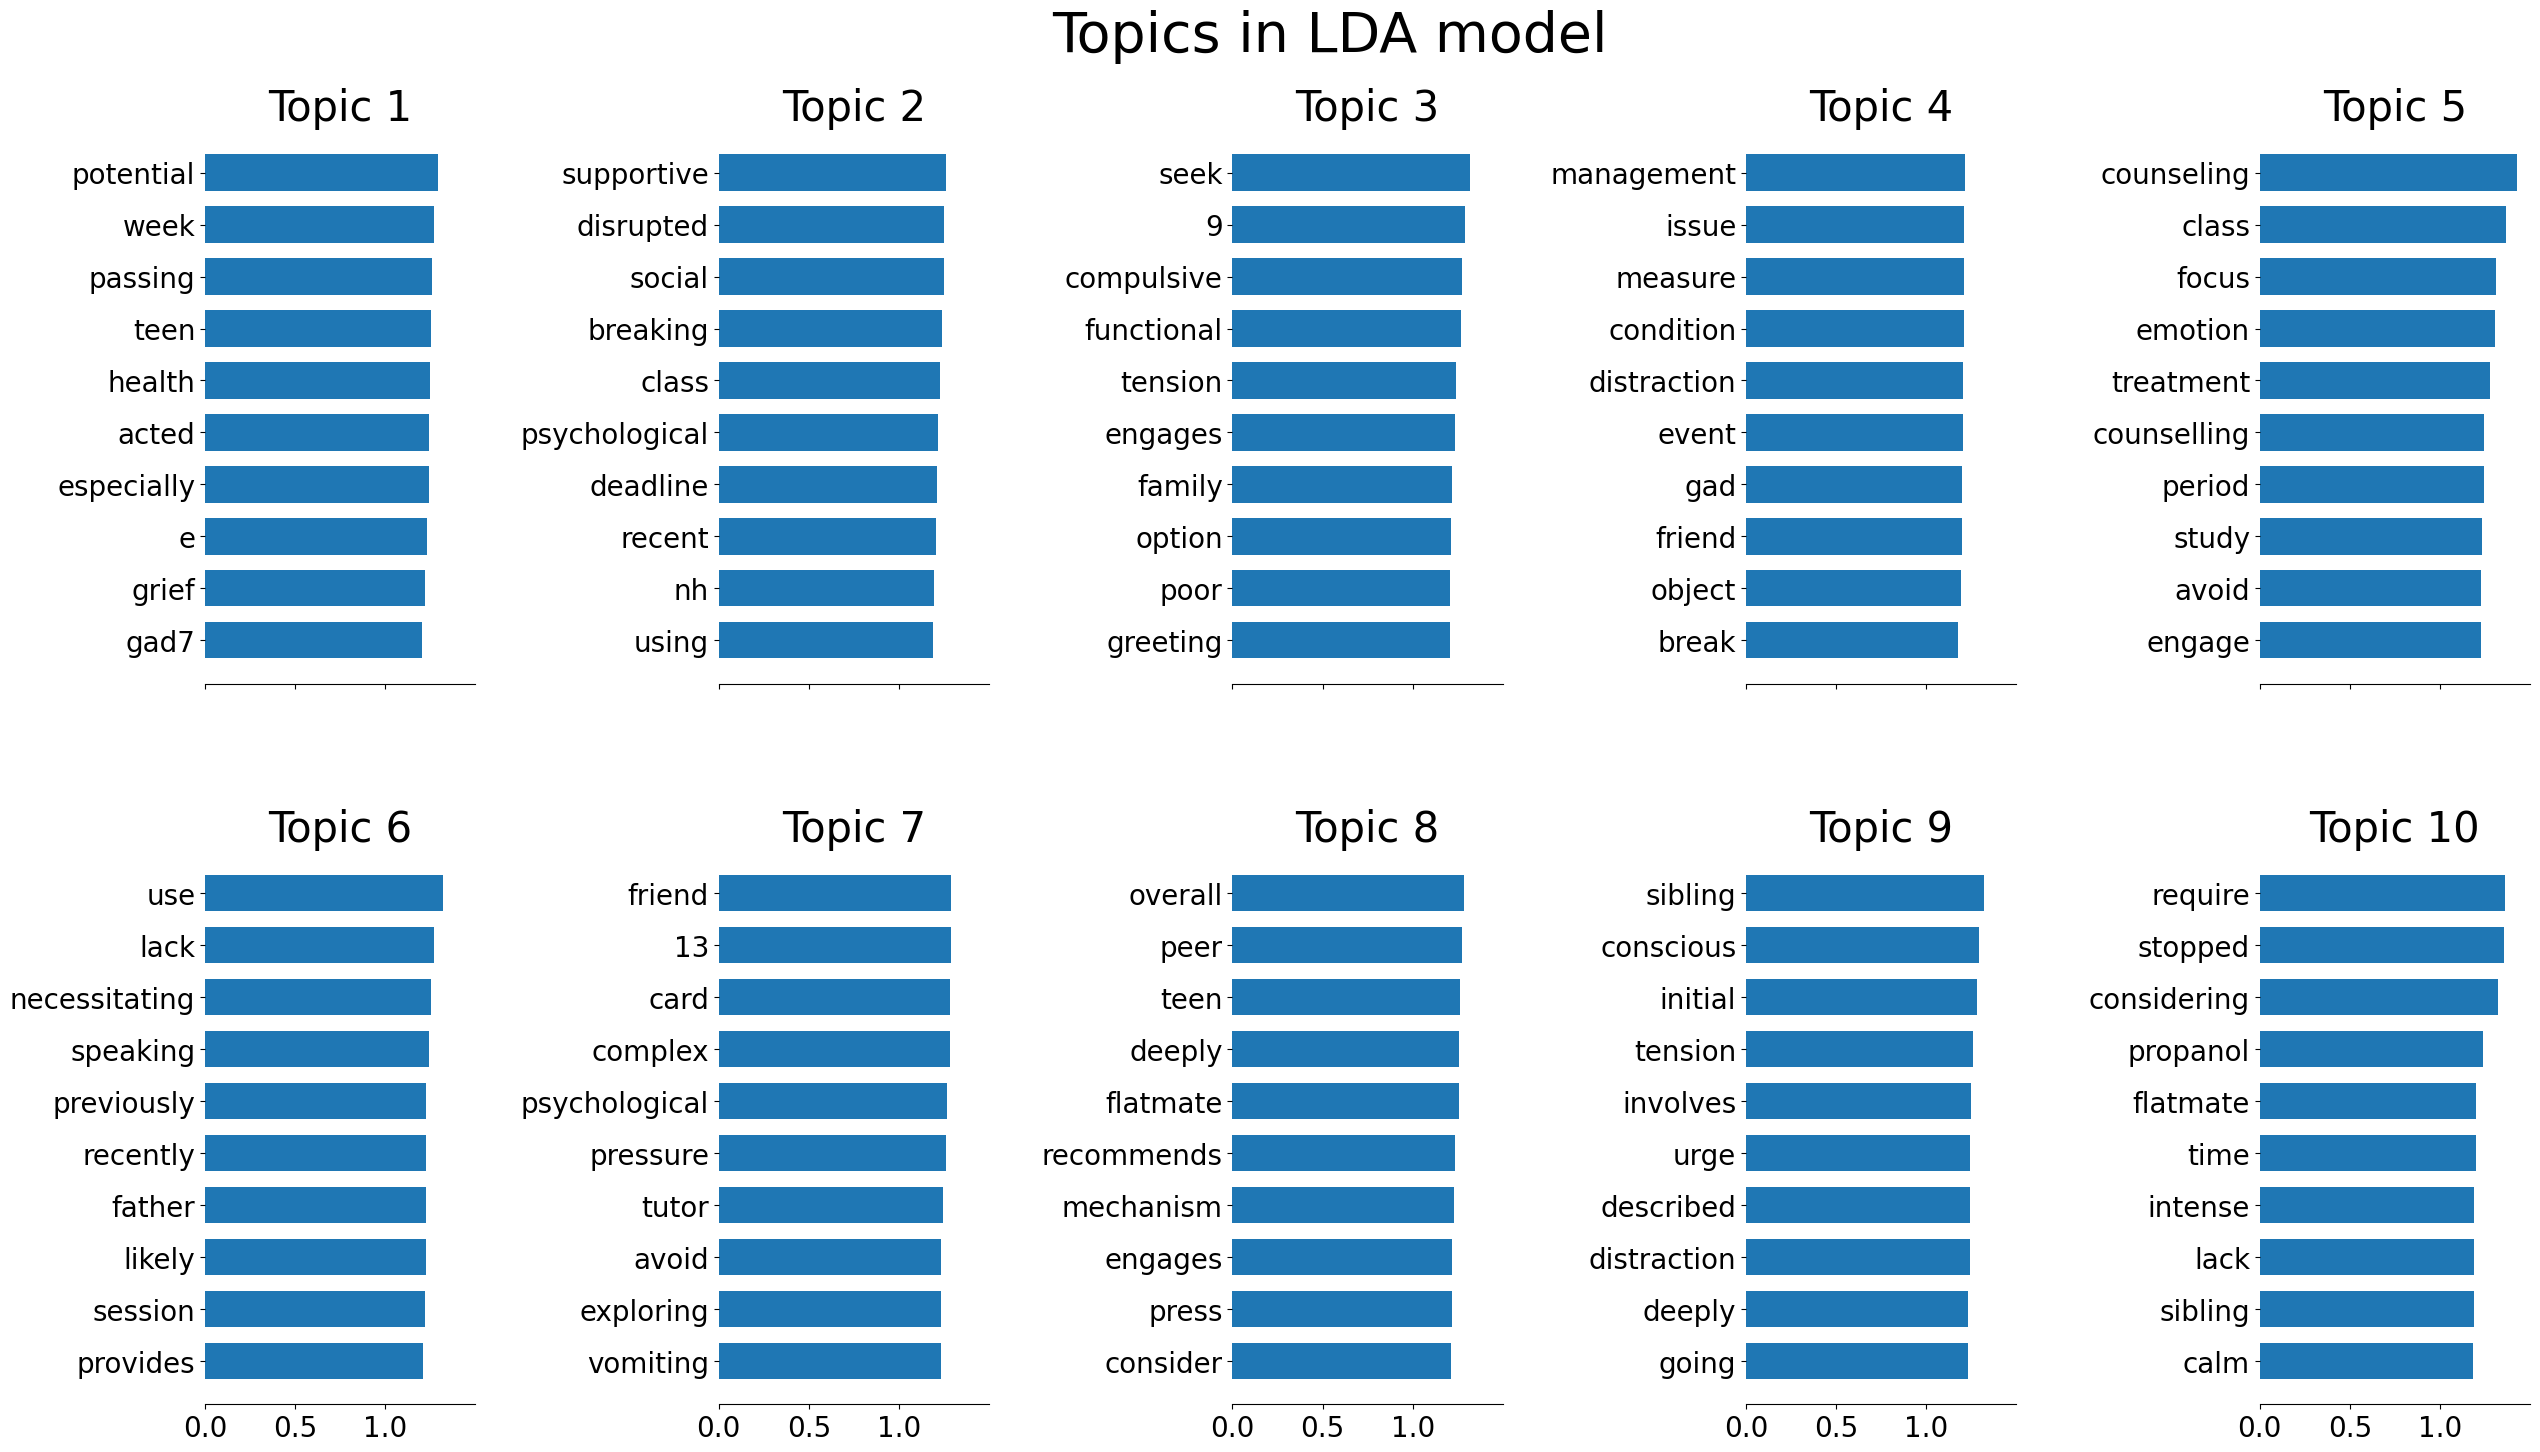

In [200]:
tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, 10, "Topics in LDA model")

In [201]:
num_words = 15
vocab = np.array(vectorizer.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [" ".join(t) for t in topic_words]

In [202]:
topics

['potential week passing teen health acted especially e grief gad7 debilitating close 18 consciousness 13',
 'supportive disrupted social breaking class psychological deadline recent nh using waking potential 40mg east away',
 'seek 9 compulsive functional tension engages family option poor greeting diagnosed sibling strong immediate year',
 'management issue measure condition distraction event gad friend object break pressing exacerbated study follow present',
 'counseling class focus emotion treatment counselling period study avoid engage academic challenge passing 40mg 15',
 'use lack necessitating speaking previously recently father likely session provides focusing harm e oneself conscious',
 'friend 13 card complex psychological pressure tutor avoid exploring vomiting greeting stopped functioning away includes',
 'overall peer teen deeply flatmate recommends mechanism engages press consider mental placement check initially acting',
 'sibling conscious initial tension involves urge

In [203]:
np.round(W1, 2)

array([[0.  , 0.05, 0.  , 0.11, 0.24, 0.21, 0.38, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.12, 0.  , 0.  , 0.51, 0.37, 0.  , 0.  , 0.  ],
       [0.  , 0.03, 0.  , 0.  , 0.  , 0.7 , 0.  , 0.  , 0.  , 0.27],
       [0.  , 0.62, 0.  , 0.  , 0.  , 0.38, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.86, 0.  , 0.  , 0.13, 0.  , 0.  , 0.  , 0.  ],
       [0.05, 0.3 , 0.  , 0.  , 0.  , 0.  , 0.64, 0.  , 0.  , 0.  ],
       [0.  , 0.89, 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.  , 0.  ],
       [0.  , 0.78, 0.04, 0.  , 0.  , 0.  , 0.17, 0.  , 0.  , 0.  ],
       [0.  , 0.58, 0.  , 0.  , 0.  , 0.  , 0.41, 0.  , 0.  , 0.  ],
       [0.1 , 0.07, 0.  , 0.29, 0.  , 0.  , 0.  , 0.53, 0.  , 0.  ],
       [0.14, 0.  , 0.08, 0.05, 0.  , 0.42, 0.  , 0.31, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.82, 0.  , 0.17, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.37, 0.  , 0.  , 0.  , 0.33, 0.  , 0.  , 0.29],
       [0.  , 0.48, 0.15, 0.  , 0.  , 0.  , 0.36, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.17, 0.  , 0.

## concatenate LDA features back to df

In [204]:
df

,IAPTus_Num_x,patient,round,text,summarization,labels
0,24804,24804,0,ASSESSMENT APPOINTMENT:\n\nStudent confirmed t...,"### Patient Background:\nNAME, a university st...",1.0
1,24813,24813,0,Assessment appointment\n\nRisk Assessment\n\nC...,"### Patient Background:\nNAME, a university st...",0.0
2,24816,24816,0,Student agrees with “Information for Students”...,### Patient Background:\nNAME is a university ...,0.0
3,24822_1,24822,1,ASSESSMENT APPOINTMENT:\n\nStudent confirmed t...,"### Summary of Patient Background, Symptoms, I...",0.0
4,24822_2,24822,2,Current thoughts/plans/intent to self-harm\n\n...,"**Patient Background:**\nNAME, a university st...",0.0
5,24828,24828,0,Assessment appointment\n\nExploration of CORE ...,"### Patient Background, Symptoms, Impacts, and...",0.0
6,24837,24837,0,Assessment appointment\n\nExploration of MDS s...,"### Summary of Patient Background, Symptoms, I...",1.0
7,24840,24840,0,[<50 min assessment included confidentiality l...,**Patient Background:**\nNAME has a history of...,1.0
8,24861,24861,0,Exploration of MDS scores and risk\nPHQ9 -16\n...,### Patient Background:\n- **Name**: NAME\n- *...,1.0
9,24864,24864,0,Teams AA Appointmen\n\n\nStudent agrees with “...,### Patient Background:\nNAME is a university ...,0.0


In [209]:
colnames = ["Topic" + str(i) for i in range(lda.n_components)]
df_lda = pd.DataFrame(W1, columns=colnames)
df_lda

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,0.000752,0.052864,0.000752,0.109051,0.239736,0.211229,0.383360,0.000752,0.000752,0.000752
1,0.000862,0.000862,0.116308,0.000862,0.000862,0.506693,0.370963,0.000862,0.000862,0.000862
2,0.000918,0.025400,0.000918,0.000918,0.000918,0.698997,0.000918,0.000918,0.000918,0.269179
3,0.000926,0.616895,0.000926,0.000926,0.000926,0.375696,0.000926,0.000926,0.000926,0.000926
4,0.001150,0.001150,0.859554,0.001150,0.001150,0.131248,0.001150,0.001150,0.001150,0.001150
5,0.050601,0.297018,0.001137,0.001137,0.001137,0.001137,0.644424,0.001137,0.001137,0.001137
6,0.000877,0.894971,0.000877,0.000877,0.000877,0.000877,0.098009,0.000877,0.000877,0.000877
7,0.001220,0.778592,0.044064,0.001220,0.001220,0.001220,0.168805,0.001220,0.001220,0.001220
8,0.000848,0.578985,0.000848,0.000848,0.000848,0.000848,0.410180,0.000848,0.000848,0.004900
9,0.097325,0.070317,0.000807,0.294991,0.000807,0.000807,0.000807,0.532527,0.000807,0.000807


In [212]:
df_final = pd.concat([df, df_lda], axis=1)
df_final

,IAPTus_Num_x,patient,round,text,summarization,labels,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,24804,24804,0,ASSESSMENT APPOINTMENT:\n\nStudent confirmed t...,"### Patient Background:\nNAME, a university st...",1.0,0.000752,0.052864,0.000752,0.109051,0.239736,0.211229,0.383360,0.000752,0.000752,0.000752
1,24813,24813,0,Assessment appointment\n\nRisk Assessment\n\nC...,"### Patient Background:\nNAME, a university st...",0.0,0.000862,0.000862,0.116308,0.000862,0.000862,0.506693,0.370963,0.000862,0.000862,0.000862
2,24816,24816,0,Student agrees with “Information for Students”...,### Patient Background:\nNAME is a university ...,0.0,0.000918,0.025400,0.000918,0.000918,0.000918,0.698997,0.000918,0.000918,0.000918,0.269179
3,24822_1,24822,1,ASSESSMENT APPOINTMENT:\n\nStudent confirmed t...,"### Summary of Patient Background, Symptoms, I...",0.0,0.000926,0.616895,0.000926,0.000926,0.000926,0.375696,0.000926,0.000926,0.000926,0.000926
4,24822_2,24822,2,Current thoughts/plans/intent to self-harm\n\n...,"**Patient Background:**\nNAME, a university st...",0.0,0.001150,0.001150,0.859554,0.001150,0.001150,0.131248,0.001150,0.001150,0.001150,0.001150
5,24828,24828,0,Assessment appointment\n\nExploration of CORE ...,"### Patient Background, Symptoms, Impacts, and...",0.0,0.050601,0.297018,0.001137,0.001137,0.001137,0.001137,0.644424,0.001137,0.001137,0.001137
6,24837,24837,0,Assessment appointment\n\nExploration of MDS s...,"### Summary of Patient Background, Symptoms, I...",1.0,0.000877,0.894971,0.000877,0.000877,0.000877,0.000877,0.098009,0.000877,0.000877,0.000877
7,24840,24840,0,[<50 min assessment included confidentiality l...,**Patient Background:**\nNAME has a history of...,1.0,0.001220,0.778592,0.044064,0.001220,0.001220,0.001220,0.168805,0.001220,0.001220,0.001220
8,24861,24861,0,Exploration of MDS scores and risk\nPHQ9 -16\n...,### Patient Background:\n- **Name**: NAME\n- *...,1.0,0.000848,0.578985,0.000848,0.000848,0.000848,0.000848,0.410180,0.000848,0.000848,0.004900
9,24864,24864,0,Teams AA Appointmen\n\n\nStudent agrees with “...,### Patient Background:\nNAME is a university ...,0.0,0.097325,0.070317,0.000807,0.294991,0.000807,0.000807,0.000807,0.532527,0.000807,0.000807


In [227]:
# Keep 10% data as the test data
train, test = train_test_split(df_final, test_size=0.1)
train.shape

(38, 16)

## train a xgboost

In [228]:
classifier_lda = xgb.XGBRegressor(objective="binary:logistic", random_state=42)

In [229]:
classifier_lda.fit(train[colnames], train["labels"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='binary:logistic', ...)

In [230]:
predicted_train_tfidf = classifier_lda.predict(train[colnames])
accuracy_train_tfidf = accuracy_score(train["labels"], (predicted_train_tfidf>0.5))
print('Accuracy Training data: {:.1%}'.format(accuracy_train_tfidf))

predicted_test_tfidf = classifier_lda.predict(test[colnames])
accuracy_test_tfidf = accuracy_score(test["labels"], (predicted_test_tfidf>0.5))
accuracy_tfidf = accuracy_test_tfidf
print('Accuracy Test data: {:.1%}'.format(accuracy_test_tfidf))

Accuracy Training data: 100.0%
Accuracy Test data: 100.0%


# Useless code

In [26]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

done in 0.028s.


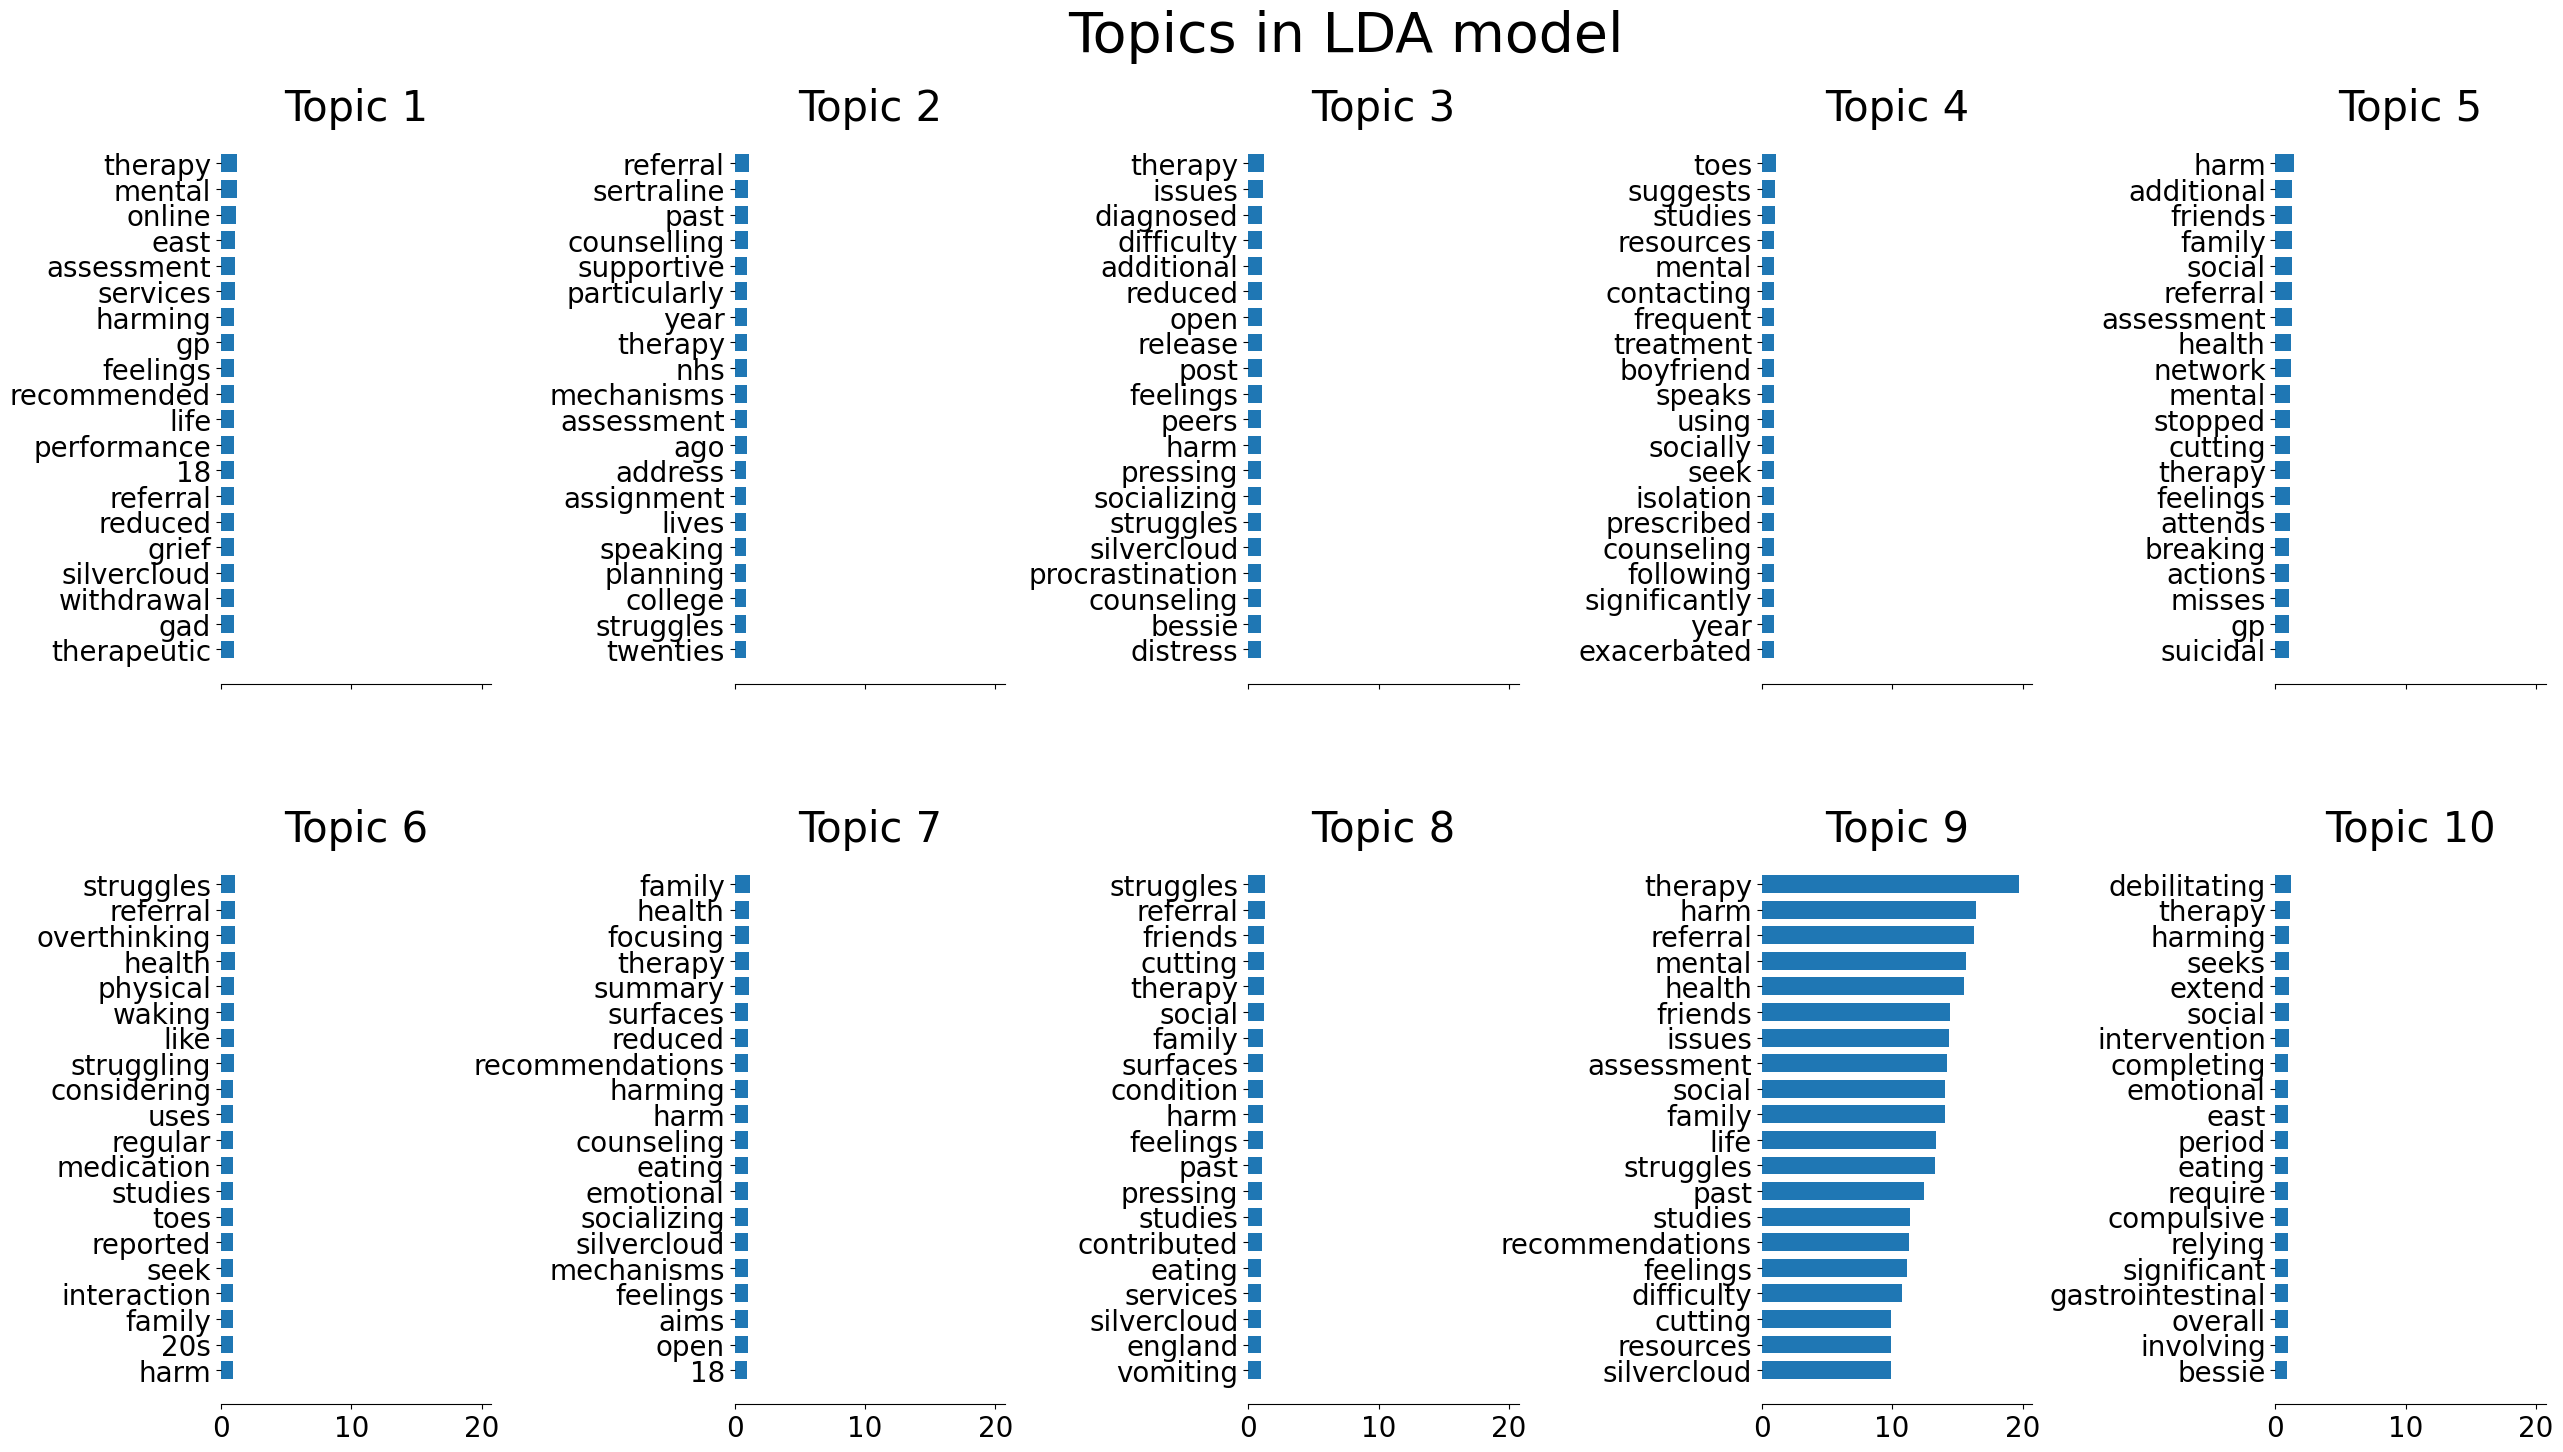

In [27]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(df["summarization"])

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

# Useless code

## Train

In [11]:
import matplotlib as plt
from matplotlib import cm

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_val_score, )
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from tomotopy import HDPModel

# from lda_classification.model import TomotopyLDAVectorizer
# from lda_classification.preprocess.spacy_cleaner import SpacyCleaner

In [12]:
workers = 4 #Numbers of workers throughout the project

use_umap = False #make this True if you want to use UMAP for your visualizations

min_df = 5 #Minimum number for document frequency in the corpus
rm_top = 5 #Remove top n frequent words

In [13]:
hdp_model = HDPModel(min_df=min_df, rm_top=rm_top)
hdp_model.optim_interval = 5
for idx, row in df.iterrows():
    hdp_model.add_doc(row["summarization"])

hdp_model.burn_in = 100
hdp_model.train(0, workers=workers)
for i in range(0, 1000, 10):
    hdp_model.train(10, workers=workers)
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp_model.ll_per_word, hdp_model.live_k))

num_of_topics = hdp_model.live_k

/tmp/ipykernel_3124103/4055823517.py:4: RuntimeWarning: `words` should be an iterable of str.
  hdp_model.add_doc(row["summarization"])


Iteration: 0	Log-likelihood: -3.44524360006526	Num. of topics: 2
Iteration: 10	Log-likelihood: -3.4480790098214458	Num. of topics: 2
Iteration: 20	Log-likelihood: -3.4402376923006397	Num. of topics: 2
Iteration: 30	Log-likelihood: -3.444616825955108	Num. of topics: 2
Iteration: 40	Log-likelihood: -3.441848493063278	Num. of topics: 2
Iteration: 50	Log-likelihood: -3.4408994581467125	Num. of topics: 2
Iteration: 60	Log-likelihood: -3.4283533737155865	Num. of topics: 2
Iteration: 70	Log-likelihood: -3.425441742427575	Num. of topics: 2
Iteration: 80	Log-likelihood: -3.4234684283258954	Num. of topics: 2
Iteration: 90	Log-likelihood: -3.4150061948917054	Num. of topics: 2
Iteration: 100	Log-likelihood: -3.403096945425126	Num. of topics: 2
Iteration: 110	Log-likelihood: -3.3932992066576384	Num. of topics: 2
Iteration: 120	Log-likelihood: -3.3805796560379386	Num. of topics: 2
Iteration: 130	Log-likelihood: -3.36770709780948	Num. of topics: 2
Iteration: 140	Log-likelihood: -3.360874676555122	Num